In [1]:
import os
import sys
sys.path.append('../sdbm/code')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

2023-07-12 15:46:04.510520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 15:46:04.536272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 15:46:04.963051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
# check GPU
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))


/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-12 15:46:05.340352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 15:46:05.344064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 15:46:05.344180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
X, y = make_blobs(n_samples=200, centers=3, n_features=3, random_state=0)
X = MinMaxScaler().fit_transform(X)
clf = LogisticRegression(random_state=0).fit(X, y)

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
ssnp = SSNP(bottleneck_activation='linear', verbose=0)
ssnp.fit(X, y, )

2023-07-12 15:46:06.564098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 15:46:06.564248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 15:46:06.564300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

7/7 [==============================] - 0s 642us/step


2023-07-12 15:46:11.199985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [200,3]
	 [[{{node Placeholder/_10}}]]
2023-07-12 15:46:11.200107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [200,3]
	 [[{{node Placeholder/_10}}]]


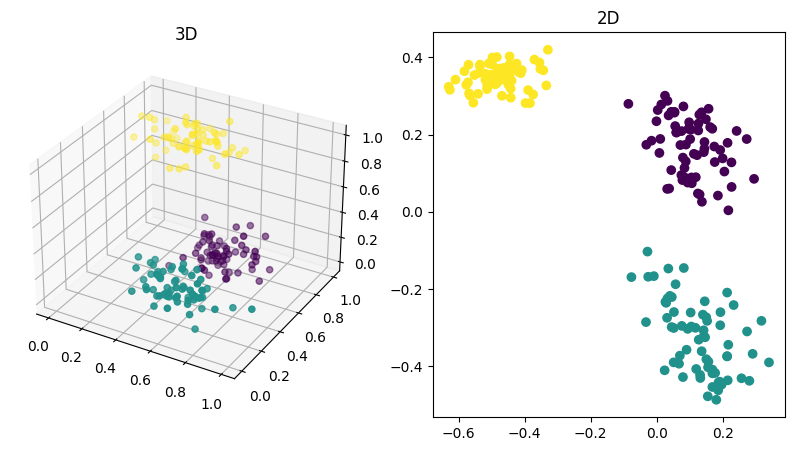

In [4]:
X_2d = ssnp.transform(X)
# plot 3d, and 2d
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_title('3D')
ax = fig.add_subplot(122)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis')
ax.set_title('2D')
plt.show()

In [19]:
class ID_finder:
    def __init__(self):
        self.LID_map = None
        self.DM = None
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

    def get_LID(self, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
        self.DM = DM

        pixel_w = 1 / grid
        xx, yy = np.meshgrid(np.linspace(0, 1, grid), np.linspace(0, 1, grid))
        XY = np.c_[xx.ravel(), yy.ravel()]

        LID_map = np.zeros(XY.shape[0])
        LID_eval = T.zeros((XY.shape[0], DM.inverse_transform([[0,0]]).shape[1])).to(self.device)

        for pix in XY:
            subset = self.get_subset(pix, pixel_w, sample_size)
            local_cov = self.compute_cov(subset)
            LID_eval[pix] = local_cov
            # value = self.process_results(local_cov, mode)
            # LID_map[pix] = value
        LID_map = self.process_results(LID_eval, mode)
        self.LID_map = LID_map.reshape(grid, grid)
        self.LID_eval = LID_eval.to('cpu').numpy()

    def get_subset(self, center, size, n_samples):
        # def sample_uniform_2d(center, size, n_samples):
        """
        Generate `n_samples` uniformly distributed within a square of `size` around `center`.

        Parameters:
        center (tuple): The center of the square (x, y).
        size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
        n_samples (int): The number of samples to generate.

        Returns:
        numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
        """
        x, y = center
        lower = [x - size/2, y - size/2]
        upper = [x + size/2, y + size/2]

        samples = np.random.uniform(lower, upper, (n_samples, 2))
        return samples

    def compute_cov(self, subset):
        # to cuda, then compute cov
        # subset = 
        # do not show the warning form tensorflow
        # os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        subset = self.DM.inverse_transform(subset)
        subset = T.tensor(subset, dtype=T.float32, device=self.device)
        cov = T.cov(subset.T)
        # comput eigenvalues
        eigvals = LA.eigvalsh(cov)
        # order the eigenvalues
        # eigvals = T.sort(eigvals, descending=True)

        return eigvals

    def process_results(self, LID_eval, mode='dim'):
        ## sort the eigenvalues, 
        LID_eval, ind = T.sort(LID_eval, descending=True)
        # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
        ### LID_eval: (n_samples, n_features)
        if mode == 'dim':
            # compute the cumulative sum
            cumsum = T.cumsum(LID_eval, dim=1)
            # find the index of the first element that is larger than 0.95
            index = T.argmax(cumsum > 0.95, dim=1)
            # return the number of dimensions
            return index + 1
        elif mode == 'percent':
            # compute the percentage of variance explained by the first 2 dimensions
            return LID_eval[:, 0] / T.sum(LID_eval, dim=1)
                
    
            

    def plot_LID(self, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=4):
        if DM != self.DM or self.LID_map is None:
            self.DM = DM
            # set the others to None
            self.get_LID(grid=grid, DM=DM, mode=mode, sample_size=sample_size)

        map = np.flip(self.LID_map, axis=0)
        if ax is None:
            plt.imshow(map, cmap=cmap)
            # cbar of this plot
            plt.colorbar()

        else:
            ax.imshow(map, cmap=cmap)
            ax.colorbar()
            # cbar of this plot
            # plt.colorbar()
            



1/1 [==============================] - 0s 14ms/step


2023-07-12 16:05:47.965875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [1,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:47.966014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [1,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.005072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]

1/1 [==============================] - 0s 14ms/step


2023-07-12 16:05:48.168111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.168239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.198855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]

1/1 [==============================] - 0s 14ms/step


2023-07-12 16:05:48.385660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.385794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.415823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]

1/1 [==============================] - 0s 14ms/step


2023-07-12 16:05:48.608671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.608816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]
	 [[{{node Placeholder/_10}}]]
2023-07-12 16:05:48.643397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4,2]

RuntimeError: "argmax_cuda" not implemented for 'Bool'

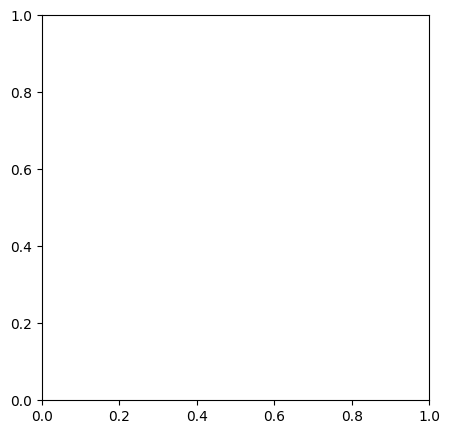

In [20]:
lid_finder = ID_finder()
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lid_finder.plot_LID(DM=ssnp, grid=5, mode='dim', ax=ax)
